In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.9 MB/s eta 0:00:00


In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,mean_squared_log_error

from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Hyperparameter tuning
# from sklearn.model_selection import GridSearchCV
import optuna

RANDOM_STATE = 42

In [5]:
# !kaggle datasets list

In [6]:
# train_df = pd.read_csv('/Users/raghavrnair/Documents/ml_project/playground-series/train.csv')
train_df = pd.read_csv('drive/MyDrive/SC4000/train.csv')

In [7]:
# test_df = pd.read_csv('/Users/raghavrnair/Documents/ml_project/playground-series/test.csv')
test_df = pd.read_csv('drive/MyDrive/SC4000/test.csv')

In [8]:
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette("hls", 8)

In [9]:
train_df.drop('id', axis = 1, inplace = True)
test_df = test_df.drop('id', axis = 1)

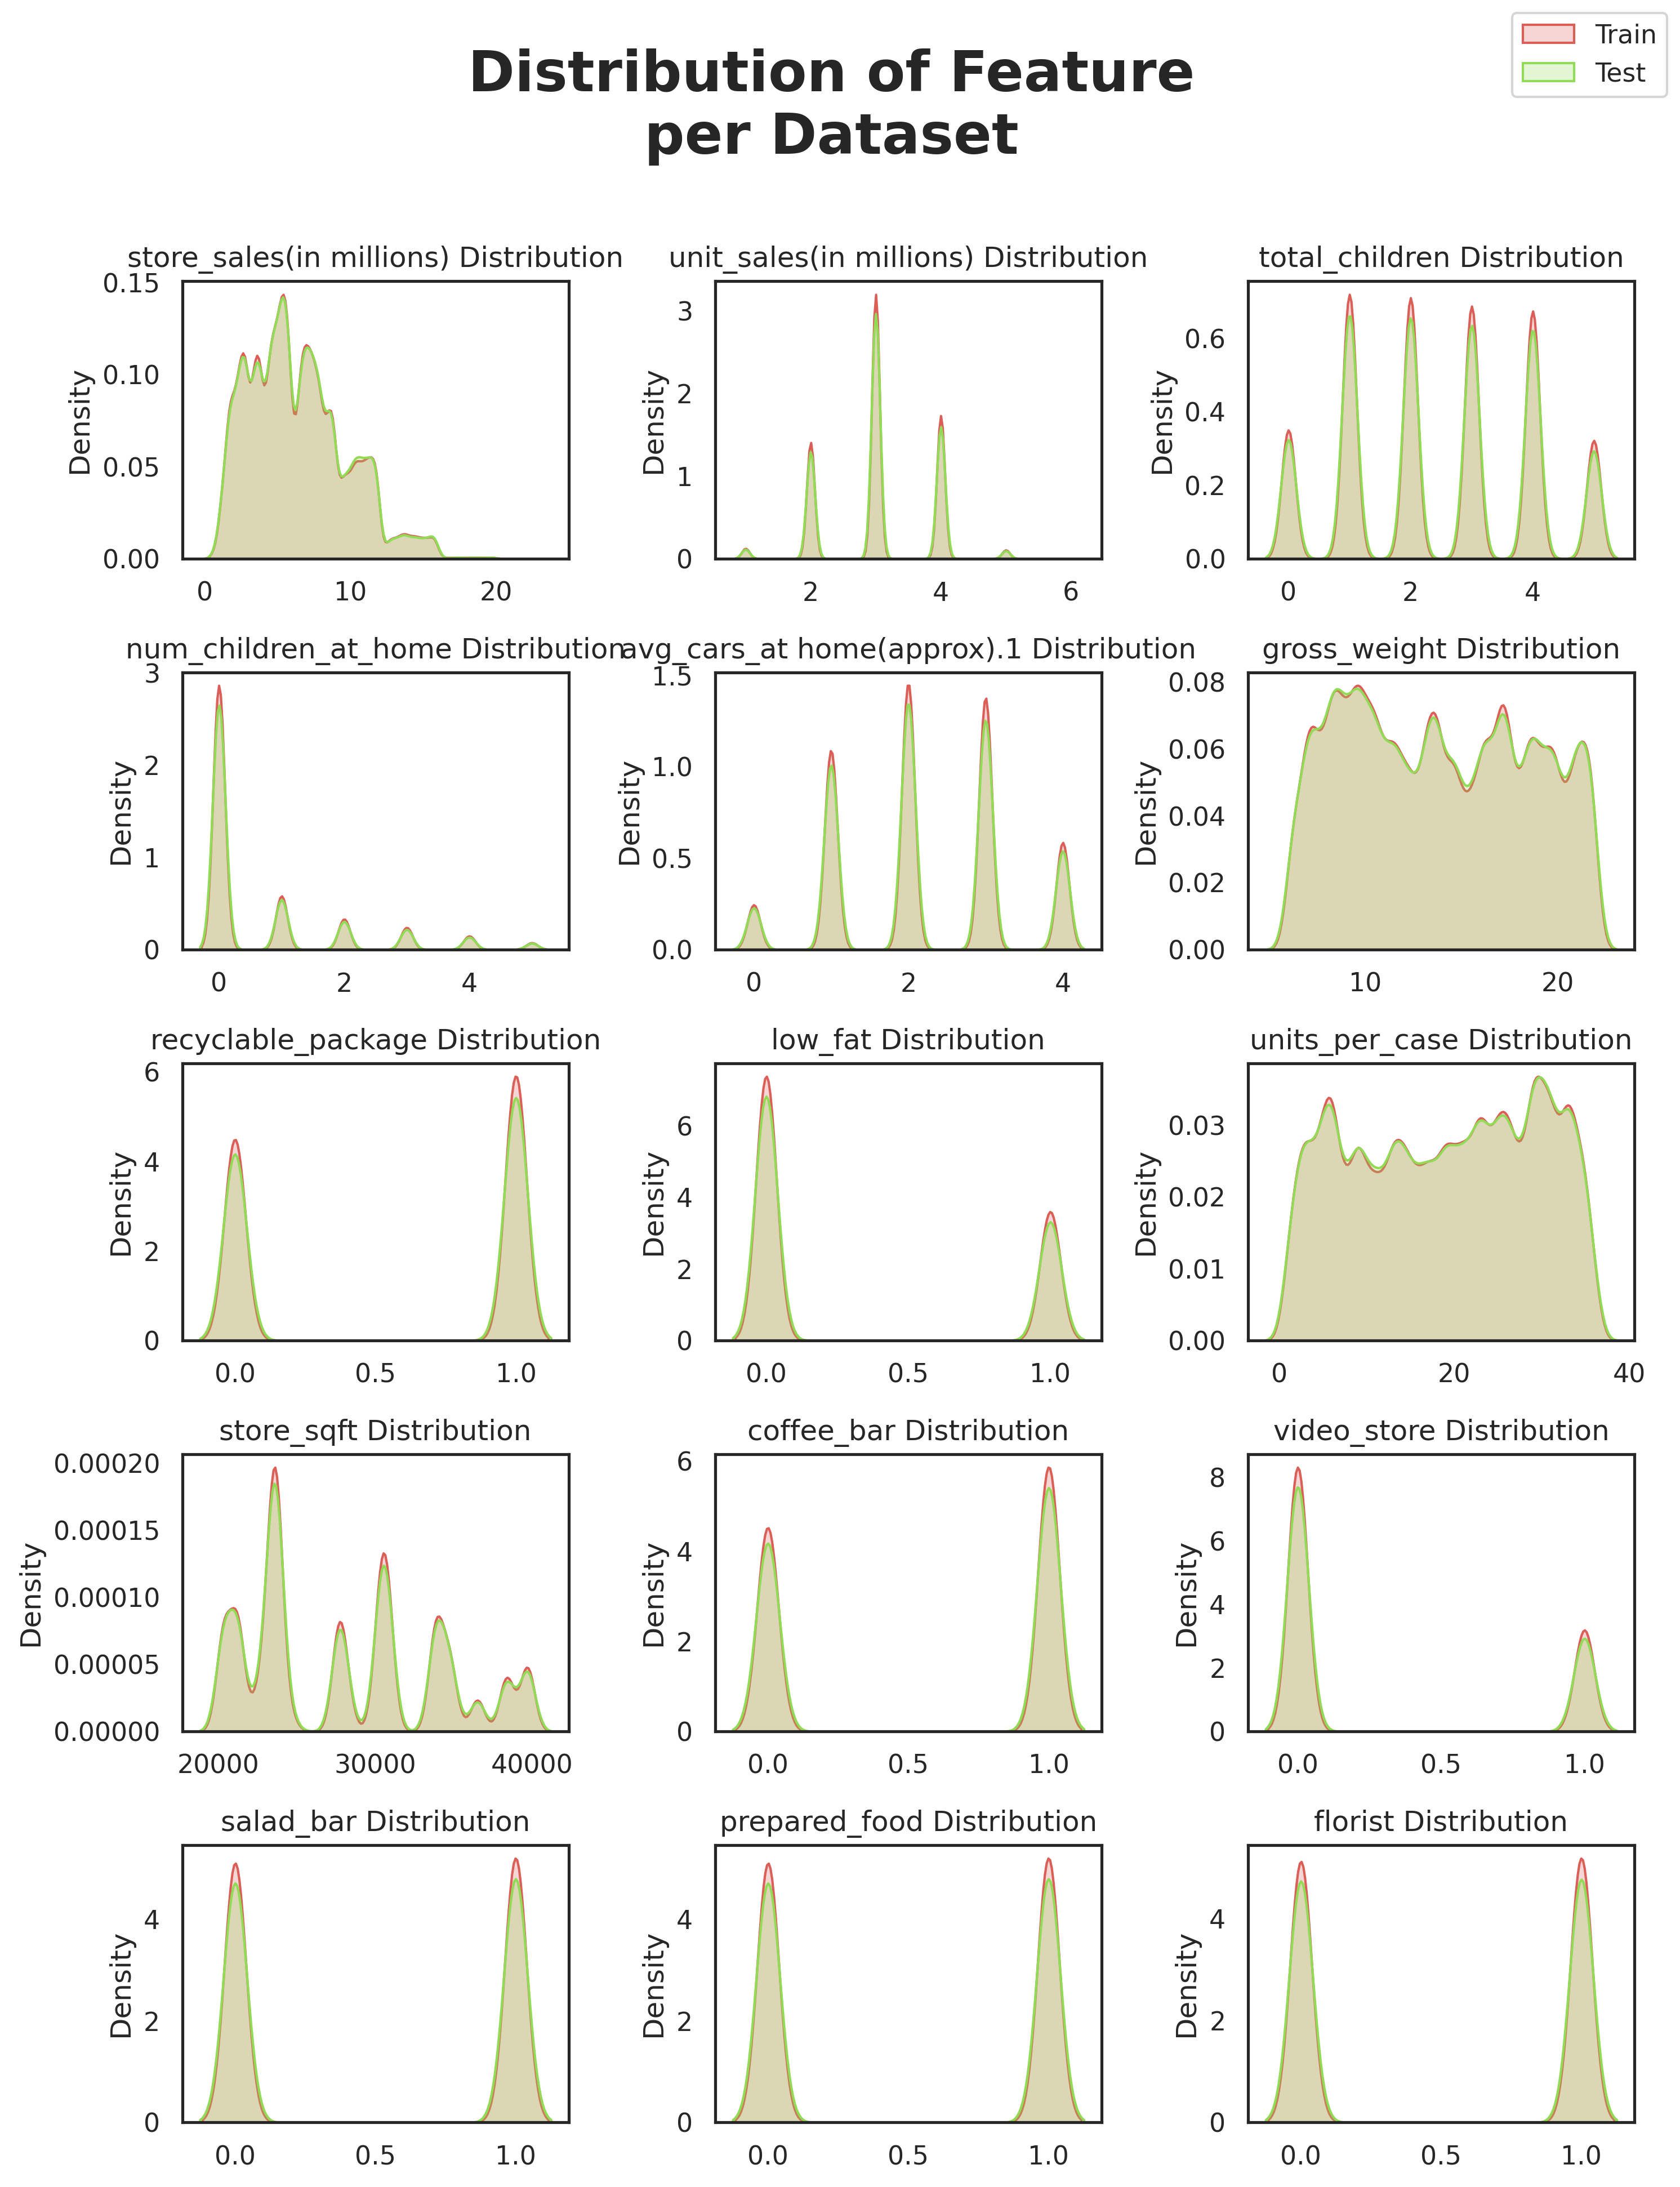

In [10]:
fig, ax = plt.subplots(5, 3, figsize = (10, 13), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test_df.columns):
    sns.kdeplot(train_df[column], ax=ax[i], color=pal[0], fill = True)
    sns.kdeplot(test_df[column], ax=ax[i], color=pal[2], fill = True)


    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

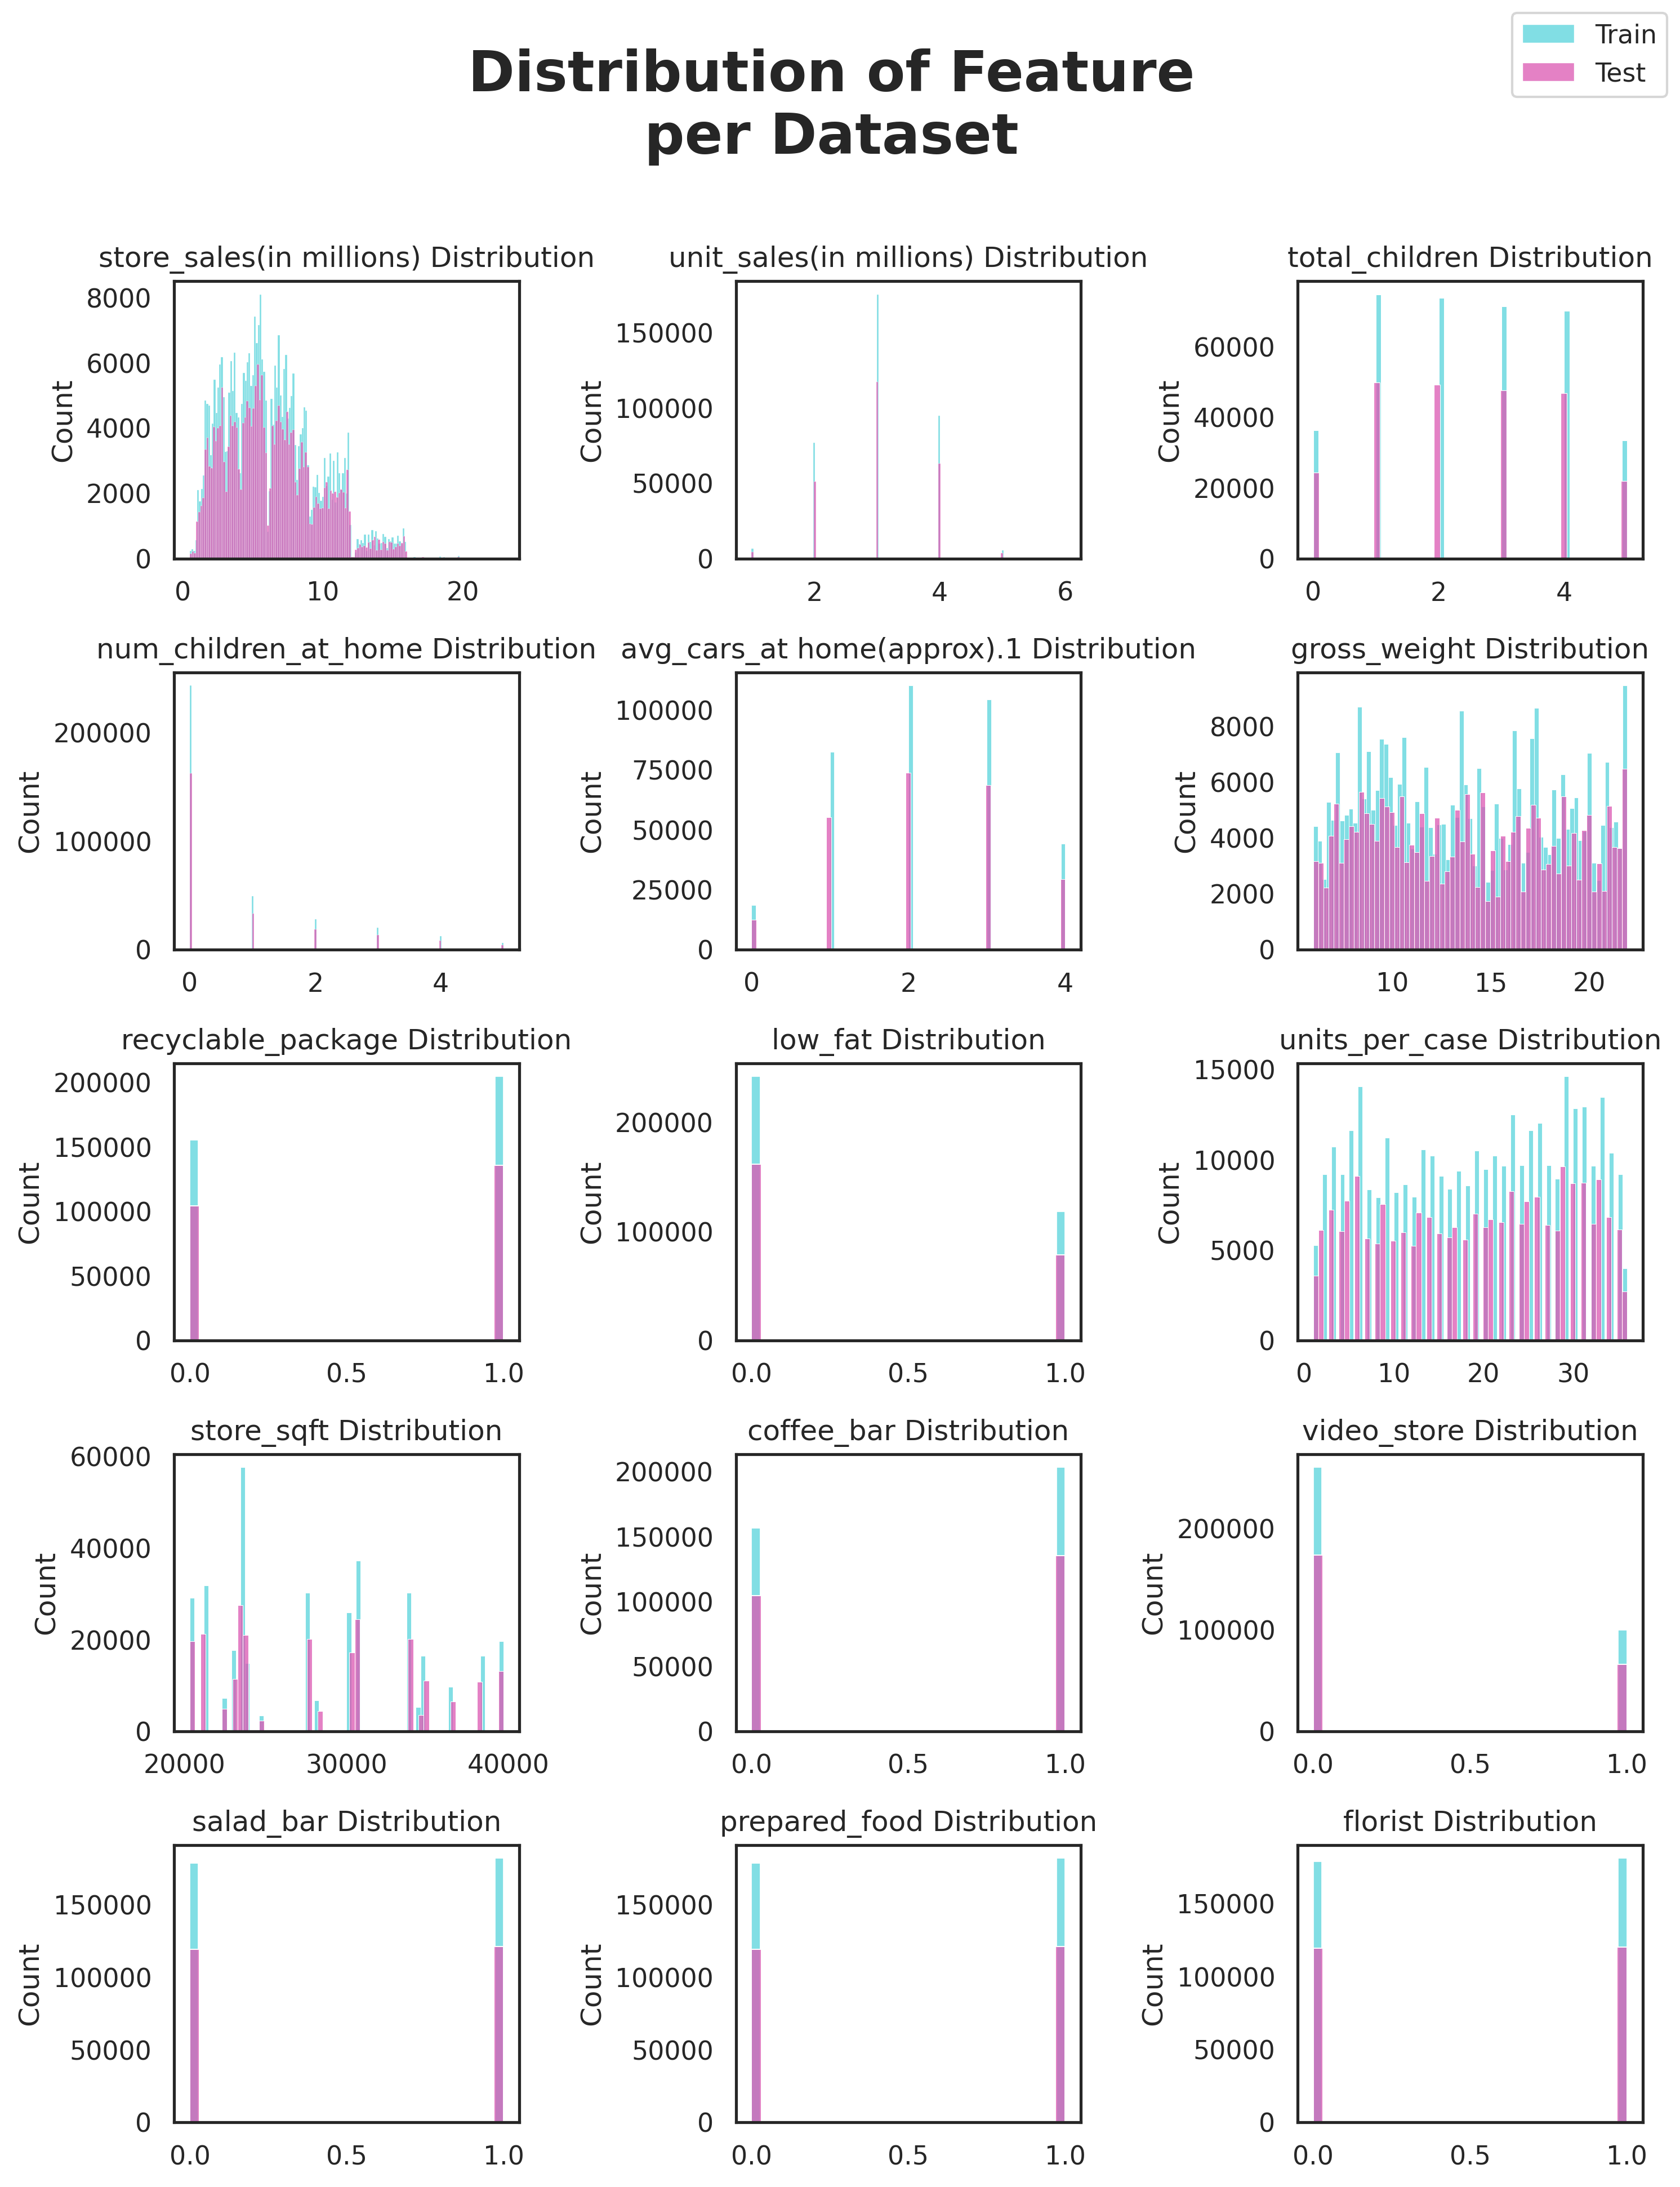

In [11]:
fig, ax = plt.subplots(5, 3, figsize = (10, 13), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(test_df.columns):
    sns.histplot(train_df[column], ax=ax[i], color=pal[4], fill = True)
    sns.histplot(test_df[column], ax=ax[i], color=pal[7], fill = True)


    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

In [12]:
def heatmap(dataset, label = None):
    corr = dataset.corr()
    plt.figure(figsize = (14, 10), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, annot = True, annot_kws = {'size' : 7}, cmap = pal)
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

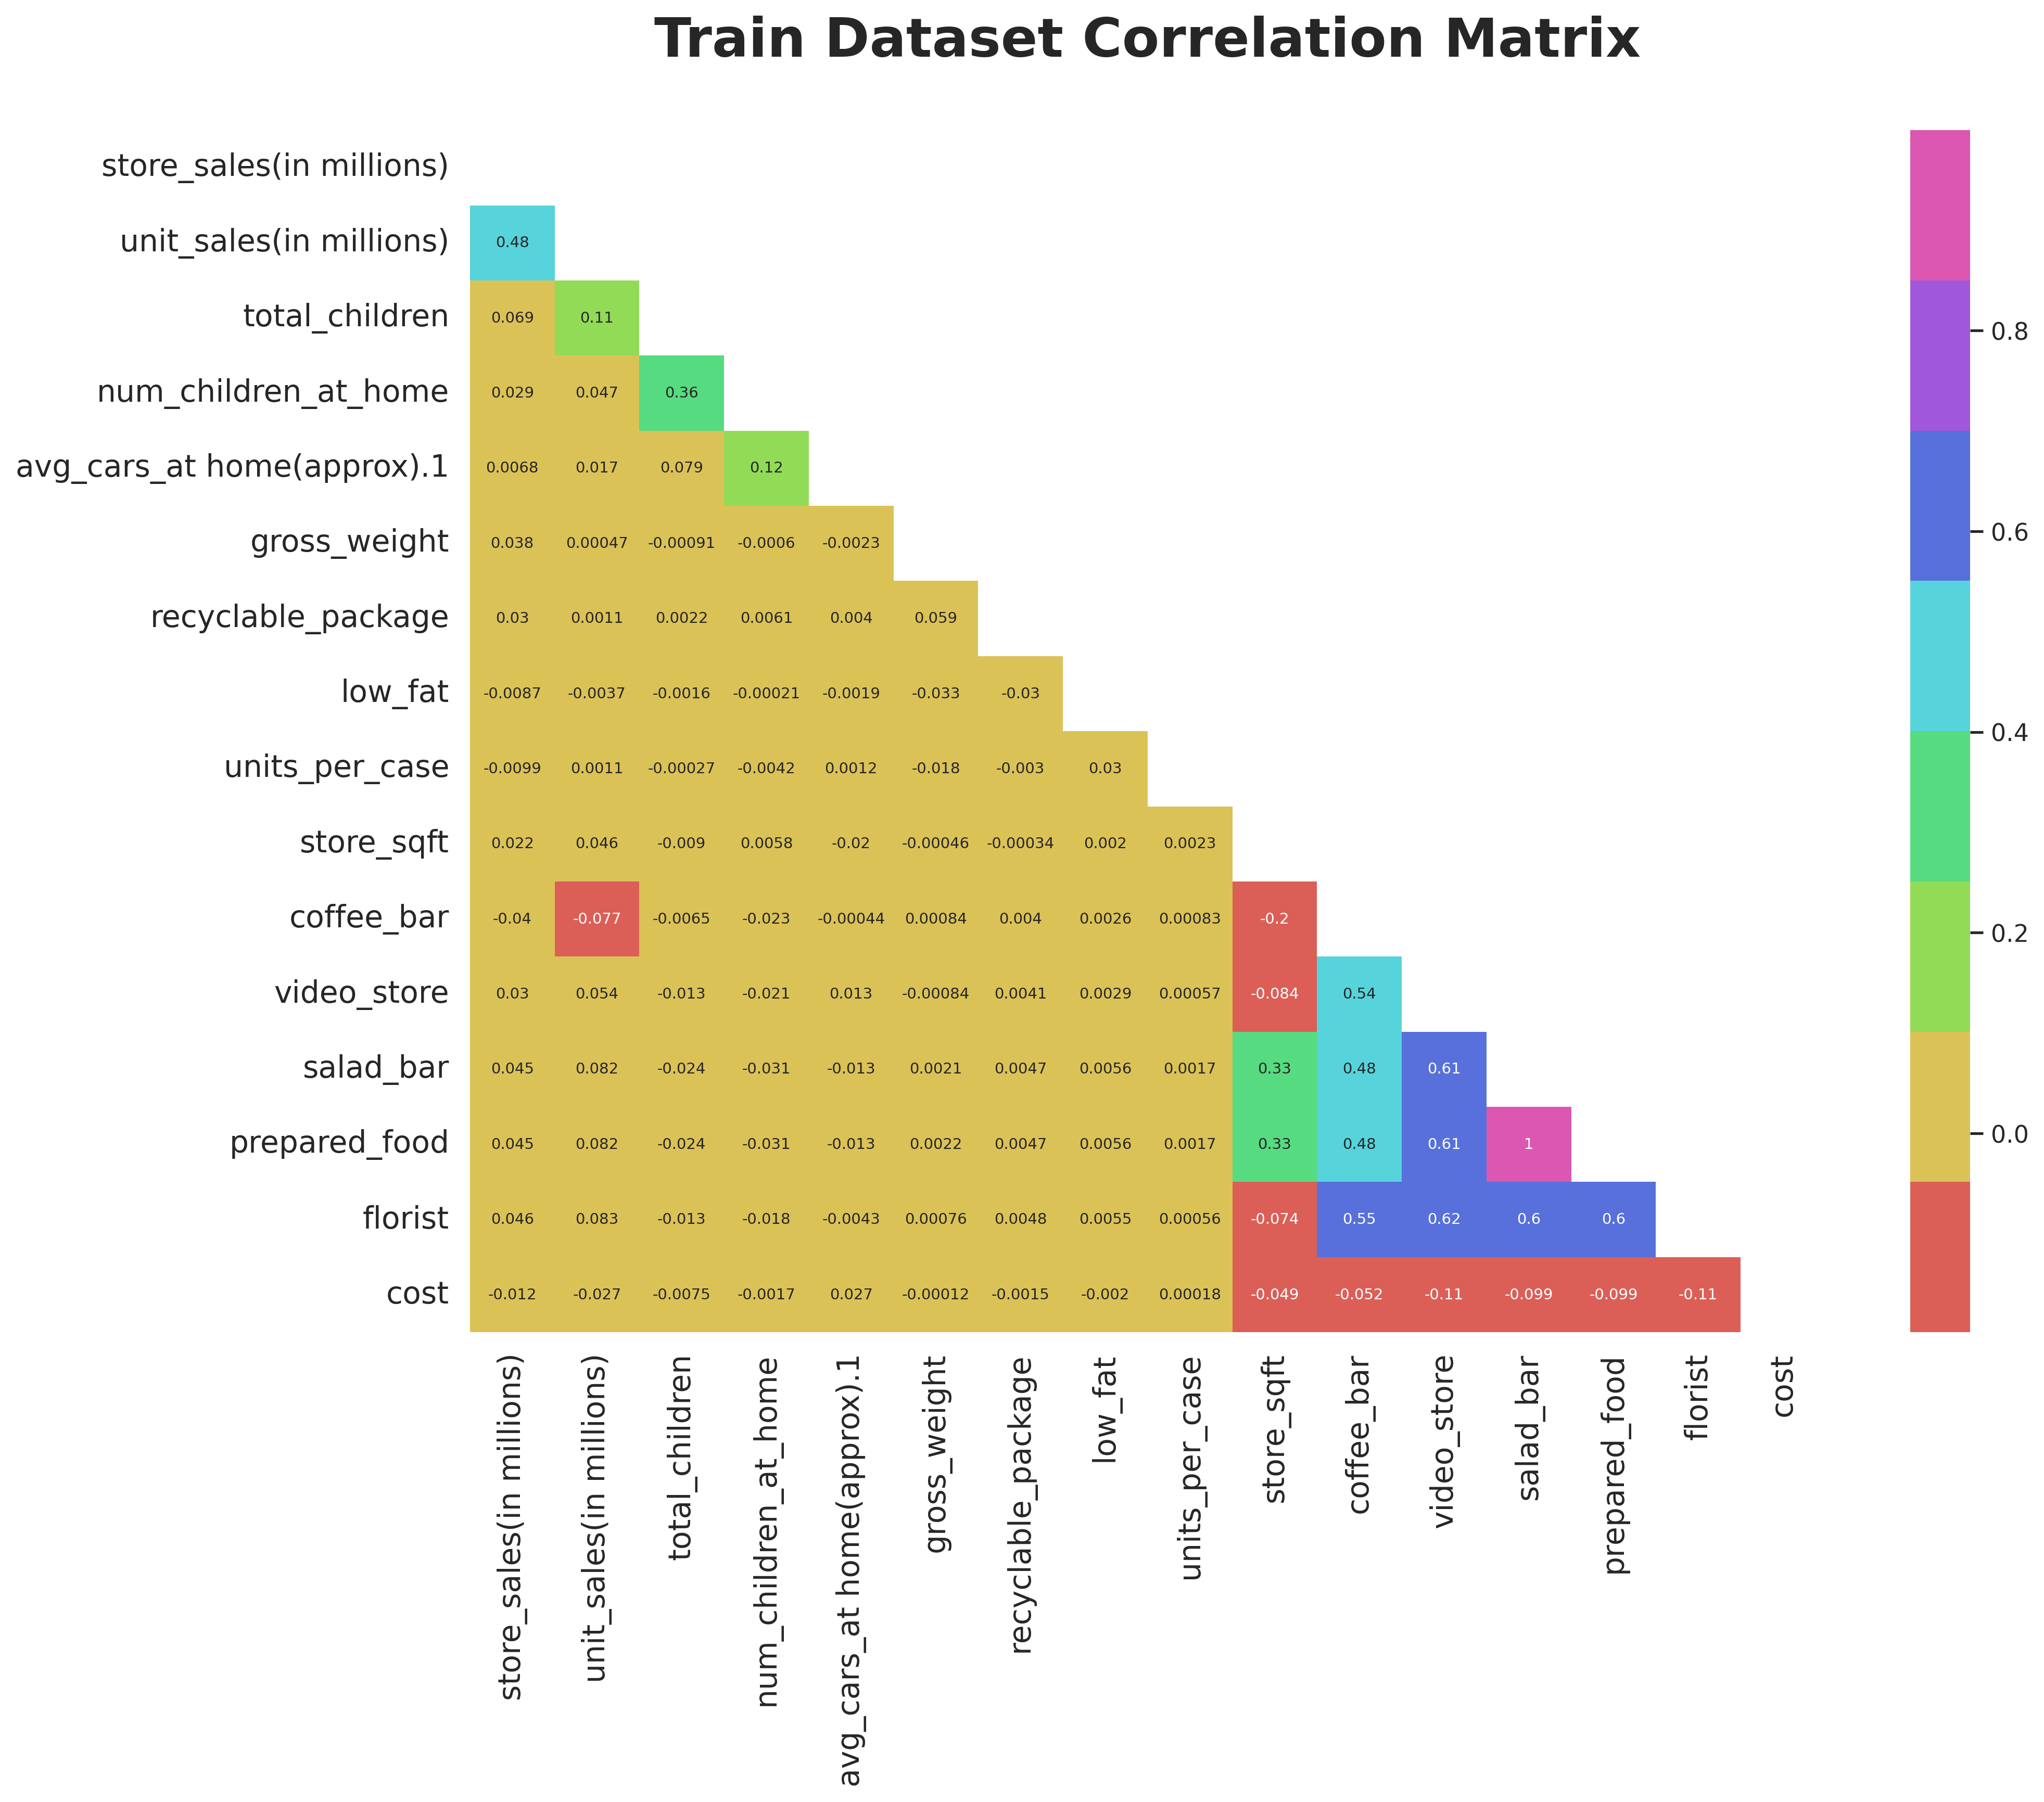

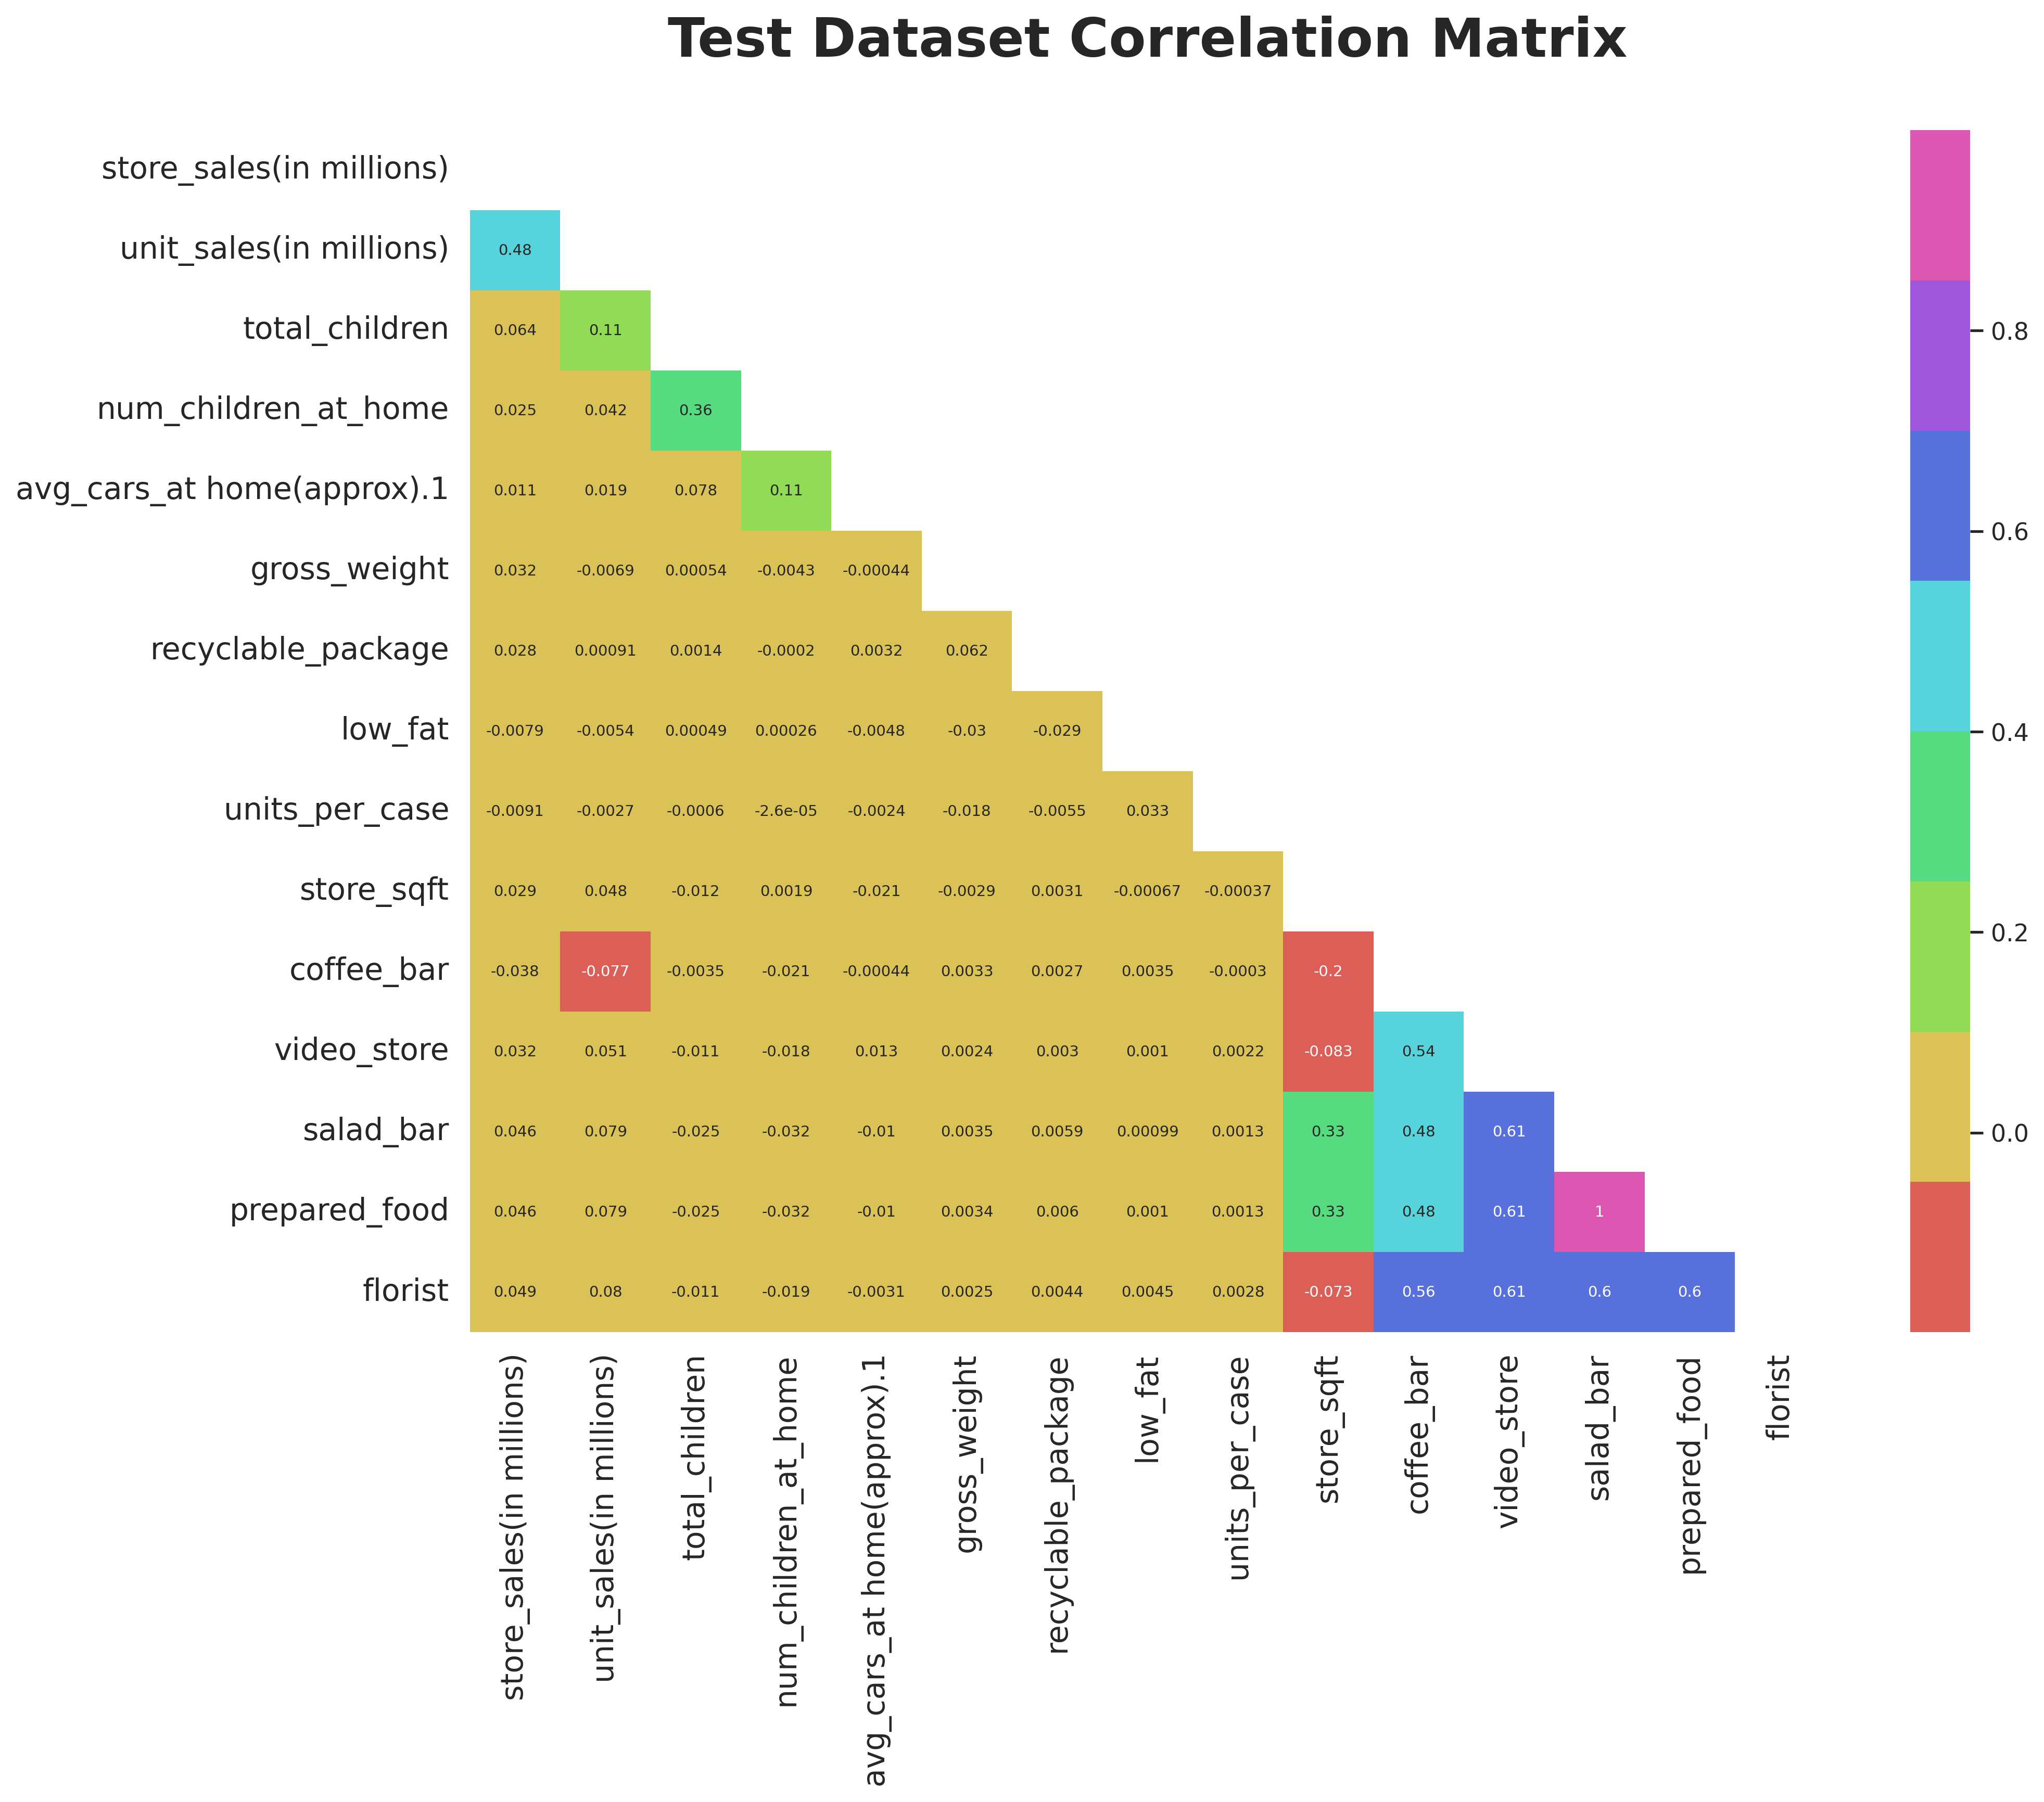

In [13]:
heatmap(train_df, 'Train')
heatmap(test_df, 'Test')

In [14]:
train_df.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [15]:
test_df.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [16]:
train_df.shape

(360336, 16)

In [17]:
train_df.tail()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
360331,7.60,4.0,5.0,5.0,3.0,13.5,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,14.44,4.0,4.0,0.0,4.0,18.8,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,10.74,3.0,0.0,0.0,2.0,11.3,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.2,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72
360335,5.30,2.0,2.0,0.0,2.0,10.8,0.0,0.0,21.0,33858.0,1.0,0.0,1.0,1.0,1.0,122.47


In [18]:
# remove prepared food
train_df.drop(columns=['prepared_food'], inplace = True)

In [19]:
train_df.shape

(360336, 15)

In [20]:
selected_features = [
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
]

In [21]:
def feature_eng(df):
    # Ratio of children at home to total_children
    df['children_per_adult']= df["num_children_at_home"] / df["total_children"]
    df['children_per_adult'].replace([np.inf, -np.inf], 10, inplace=True)
    df['children_per_adult'].fillna(0, inplace = True)

    # Weight per unit
    df["weight_per_unit"] = df["gross_weight"] / df["unit_sales(in millions)"]
    df['weight_per_unit'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    # Num of units sold per area
    df["Units_per_area"] = df["unit_sales(in millions)"] / df["store_sqft"]
    df['Units_per_area'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    # sales per unit
    df['sales_per_unit'] = df["store_sales(in millions)"] / df["unit_sales(in millions)"]
    df['sales_per_unit'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    # sales_per_unit_weight
    df['sales_per_unit_weight'] = df["store_sales(in millions)"] / df["gross_weight"]
    df['sales_per_unit_weight'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    # Sales per area of the shop
    df['sales_per_area'] = df["store_sales(in millions)"] / df["store_sqft"]
    df['sales_per_area'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    # Presence of any amenities
    df[['coffee_bar', 'video_store', 'low_fat', 'salad_bar', 'florist']] = df[['coffee_bar', 'video_store', 'low_fat', 'salad_bar', 'florist']].astype(int)

    df['any_amenities'] = df[['coffee_bar', 'video_store', 'salad_bar', 'florist']].any(axis=1)

    # Num of independent_children
    df['independent_children'] = df['total_children'] - df['num_children_at_home']
    df['independent_children'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    # Create a new feature for child-to-car ratio
    # the transportation needs of households with children
    df['child_to_car_ratio'] = df['total_children'] / df['avg_cars_at home(approx).1']
    df['child_to_car_ratio'].replace([np.inf, -np.inf], 10, inplace=True)
    df['child_to_car_ratio'].fillna(0, inplace = True)

    # Create a new feature for healthy food options
    df['healthy_food_options'] = df['low_fat'] & df['salad_bar']

    # Create a new feature for customer age group
    df['customer_age_group'] = df['total_children'] / df['num_children_at_home']
    df['customer_age_group'].replace([np.inf, -np.inf], 10, inplace=True)
    df['customer_age_group'].fillna(0, inplace = True)

    return df

In [22]:
train_df = feature_eng(train_df)
test_df = feature_eng(test_df)

In [23]:
print(train_df.shape)
print(test_df.shape)

(360336, 26)
(240224, 26)


In [24]:
# check for NaN values
print(train_df.isna().sum())
# check for infinity values
print(np.isinf(train_df).sum())

store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
florist                       0
cost                          0
children_per_adult            0
weight_per_unit               0
Units_per_area                0
sales_per_unit                0
sales_per_unit_weight         0
sales_per_area                0
any_amenities                 0
independent_children          0
child_to_car_ratio            0
healthy_food_options          0
customer_age_group            0
dtype: int64
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1 

In [25]:
# Define a function to find X and y arrays for a given dataframe either test or train
def getXy(df,X_label=None,y_label=None,cat_label=None):
    # cases that X_label is not given and it is all the features except target
    if X_label is None:
        X = df[[c for c in df.columns if c!=y_label]].values
    else:
        # Change the X array to one column when there is only one X_label
        if len(X_label) == 1:
            X = df[X_label].values.reshape(-1,1)
        else:
            # Find X based on the given X_labels when there are multiple X_labels
            X = df[X_label].values
    if y_label is None:
        # Create a zero array in the case of test set which we dont want the y_test
        y = np.zeros(df.shape[0]).reshape(-1,1)
    else:
        # calc target value and reshape it in a single column
        # y = df[y_label].values.reshape(-1,1)
        y = df[y_label].values
        # Feature Scaling
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

    # Use One Hot encoding for categorical features
    if cat_label is None:
        # create a new dataframe with X and Y
        label = np.hstack((X_label,y_label))
        data = pd.DataFrame(np.hstack((X,y.reshape(-1,1))), columns=label)
    else:
        data = pd.get_dummies(df, columns = cat_label)
    return data,X, y

In [26]:
# Scale the store_sqft column using MinMaxScaler
scaler = MinMaxScaler()
train_df['store_sqft'] = scaler.fit_transform(train_df[['store_sqft']])
test_df['store_sqft'] = scaler.fit_transform(test_df[['store_sqft']])

In [27]:
engineer_labels = ['children_per_adult','independent_children','customer_age_group','any_amenities','child_to_car_ratio']
selected_features.extend(engineer_labels)
print(selected_features)

['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'florist', 'children_per_adult', 'independent_children', 'customer_age_group', 'any_amenities', 'child_to_car_ratio']


In [28]:
names = list(train_df.columns)
print(names)
item_to_remove=['recyclable_package','store_sales(in millions)','units_per_case',
                'low_fat','gross_weight','unit_sales(in millions)','cost']
for i in item_to_remove:
    names.remove(i)
names.extend(engineer_labels)
features = [c for c in names if c!="cost"]
print(names)

['store_sales(in millions)', 'unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'florist', 'cost', 'children_per_adult', 'weight_per_unit', 'Units_per_area', 'sales_per_unit', 'sales_per_unit_weight', 'sales_per_area', 'any_amenities', 'independent_children', 'child_to_car_ratio', 'healthy_food_options', 'customer_age_group']
['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'florist', 'children_per_adult', 'weight_per_unit', 'Units_per_area', 'sales_per_unit', 'sales_per_unit_weight', 'sales_per_area', 'any_amenities', 'independent_children', 'child_to_car_ratio', 'healthy_food_options', 'customer_age_group', 'children_per_adult', 'independent_children', 'customer_age_group', 'any_amenities', 'child_to_car_ratio']


In [29]:
train,X,y = getXy(train_df,X_label=names,y_label="cost")
print(X.shape)
print(y.shape)

(360336, 24)
(360336,)


In [30]:
test,X_,y_ = getXy(test_df,X_label=names)
print(X_.shape)
print(y_.shape)

(240224, 24)
(240224, 1)


In [31]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)
print(f'Training set has {X_train.shape} examples and test set has {X_test.shape}.')

Training set has (288268, 24) examples and test set has (72068, 24).


# Models

In [32]:
RMSLE = {} # Root Mean Squared Log Error
def rmsle(y_test, y_pred):
    return mean_squared_log_error(y_test, y_pred, squared = False)

## CatBoost Regressor

https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

*   Developed in 2017 by a company named Yandex
*   Able to integrate a variety of different data types, such as images, audio, or text features into one framework
*   Does not require categorical feature transformation from non-numeric to numeric values
*   Boosting - Sequential combination of many weak models (a model performing slightly better than random chance) to create a strong competitive predictive model through greedy search
*   Oblivious growing procedure of decision trees - trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations.
*   Ordered boosting - The order of processing training instances is dynamically determined based on the gradients of the loss function with respect to the predictions. Instances with larger gradients, indicating higher errors, are considered first, while instances with smaller gradients are considered later.
*   Pros:
    *   Simple fitting scheme
    *   Higher CPU efficiency
    *   Risk of overfitting reduced using regularization techniques and tree constraints - symmetric tree structure, which constrains trees to have the same depth
    *   Faster convergence by focusing on instances that are more challenging to predict, leading to more effective updates to model parameters

In [33]:
catb_reg = CatBoostRegressor(verbose = 0)
catb_reg.fit(X_train, y_train)
y_pred = catb_reg.predict(X_test)

RMSLE['Cat Boost'] = rmsle(y_test, y_pred)
print(RMSLE)

{'Cat Boost': 0.3016560897966655}


### Parameter Optimisation using Optuna

In [34]:
def objective_catb(trial):
    params = {
        'iterations': 1000, # number of trees
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log = True),
        'depth': trial.suggest_int('depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0), # fraction of features to choose when determining the best split for each node at a specific level
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100), # minimum number of samples required to create a leaf
    }

    catb_reg_opt = CatBoostRegressor(**params, silent = True)
    catb_reg_opt.fit(X_train, y_train)
    y_pred = catb_reg_opt.predict(X_test)

    return rmsle(y_test, y_pred)

In [35]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective_catb, n_trials = 30)

[I 2024-04-07 11:44:58,815] A new study created in memory with name: no-name-a0db0820-5483-45d0-856b-615c5a6ccf5a
[I 2024-04-07 11:45:24,461] Trial 0 finished with value: 0.3078186946160928 and parameters: {'learning_rate': 0.021865210953453066, 'depth': 5, 'subsample': 0.07353101269981238, 'colsample_bylevel': 0.6116675107670482, 'min_data_in_leaf': 34}. Best is trial 0 with value: 0.3078186946160928.
[I 2024-04-07 11:47:14,409] Trial 1 finished with value: 0.30431437899422964 and parameters: {'learning_rate': 0.0036013373119516885, 'depth': 10, 'subsample': 0.5432826395214964, 'colsample_bylevel': 0.9187246395091601, 'min_data_in_leaf': 31}. Best is trial 1 with value: 0.30431437899422964.
[I 2024-04-07 11:47:50,392] Trial 2 finished with value: 0.30465005077772617 and parameters: {'learning_rate': 0.08233685548972909, 'depth': 4, 'subsample': 0.5128721402680463, 'colsample_bylevel': 0.9111332273655608, 'min_data_in_leaf': 74}. Best is trial 1 with value: 0.30431437899422964.
[I 2024

In [36]:
print('Best hyperparameters:', study.best_params)

RMSLE['Cat Boost Optimised'] = study.best_value
print('Best RMSE:', RMSLE['Cat Boost Optimised'])

Best hyperparameters: {'learning_rate': 0.05989207530082648, 'depth': 10, 'subsample': 0.4978884352423685, 'colsample_bylevel': 0.14232096507723183, 'min_data_in_leaf': 47}
Best RMSE: 0.30036001410451607


## Extremely Randomised Trees (Extra Trees Regressor)

*   Ensemble of different de-correlated decision trees
*   Difference between Extra Trees Regressor and Random Forest - No bootstrap aggregation, i.e., a random subset of data is taken without replacement. Instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.
    *   This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.
*   Parameters:
    *   n_estimators - number of trees in the forest. Larger trees => better performance but longer computation time. Results stop getting significantly better beyond a critical number of trees.
    *   max_features - size of random subsets of features to consider when splitting a node. Lower value => greater reduction in variance, but higher increase in bias.

In [37]:
ex_tree_reg = ExtraTreesRegressor(n_estimators = 100, random_state = RANDOM_STATE)
ex_tree_reg.fit(X_train, y_train)
y_pred = ex_tree_reg.predict(X_test)

RMSLE['Extra Trees'] = rmsle(y_test, y_pred)
print(RMSLE)

{'Cat Boost': 0.3016560897966655, 'Cat Boost Optimised': 0.30036001410451607, 'Extra Trees': 0.3348650647677136}


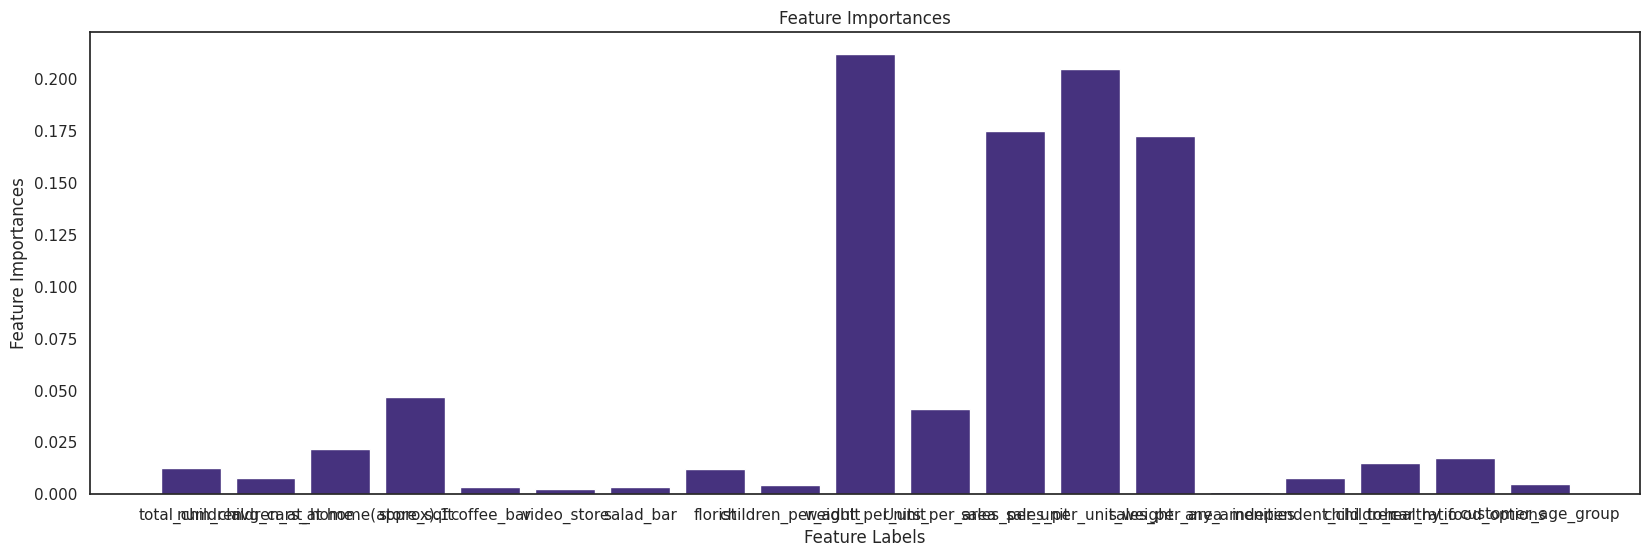

In [40]:
feature_importance = ex_tree_reg.feature_importances_
plt.figure(figsize = (20, 6))
plt.bar(names, feature_importance)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Feature Importances')
plt.show()

### Parameter Optimisation using Optuna

In [41]:
def objective_ex_tree(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), # minimum number of samples required to split an internal node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), # minimum number of samples required to be at a leaf node
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

    ex_tree_reg_opt = ExtraTreesRegressor(**params)
    ex_tree_reg_opt.fit(X_train, y_train)
    y_pred = ex_tree_reg_opt.predict(X_test)

    return rmsle(y_test, y_pred)

In [42]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective_ex_tree, n_trials = 30)

[I 2024-04-07 12:15:31,522] A new study created in memory with name: no-name-fe9d2aa9-3ed2-45c5-9c4f-444333e72fd0
[I 2024-04-07 12:17:28,401] Trial 0 finished with value: 0.30815236266298474 and parameters: {'n_estimators': 495, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.30815236266298474.
[I 2024-04-07 12:19:33,093] Trial 1 finished with value: 0.31260259799402207 and parameters: {'n_estimators': 662, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.30815236266298474.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[I 2024-04-07 12:29:34,462] Trial

In [43]:
print('Best hyperparameters:', study.best_params)

RMSLE['Extra Trees Optimised'] = study.best_value
print('Best RMSLE:', RMSLE['Extra Trees Optimised'])

Best hyperparameters: {'n_estimators': 267, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'auto'}
Best RMSLE: 0.2980603227451805


In [44]:
RMSLE

{'Cat Boost': 0.3016560897966655,
 'Cat Boost Optimised': 0.30036001410451607,
 'Extra Trees': 0.3348650647677136,
 'Extra Trees Optimised': 0.2980603227451805}